# Intro to Raster data
We will first be using the rasterio package to load and deal with raster data


In [16]:
import rasterio
import rasterio.plot
import rasterio.merge 
import rasterio.mask
import pyproj
import osmnx as ox
import geopandas as gpd
import pandas as pd
import fiona
from osgeo import gdal
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Getting topological raster data
We're going to use a Digital Elevation Model from USGS. 

You can search for data products from USGS [here](https://apps.nationalmap.gov/downloader/). We are using elevation products (3DEP) at 1/3 arc-second (~10m) resolution. Each tile spans 1x1 degree.

These files are quite large - it will take a while to download.

In [2]:
# Get raster of boston-area elevations (takes a while)
tile1_url = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n43w072/USGS_13_n43w072.tif'
tile2_url = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/TIFF/current/n43w071/USGS_13_n43w071.tif'

# we'll write them to local files so we don't have to keep downloading
local_tile1_location = 'output/local_tile1.tif'
local_tile2_location = 'output/local_tile2.tif'

!mkdir -p output

def download_to_local(tile_url, local_tile_path):
    '''
    Function to download a raster file to local_tile_path
    '''
    with rasterio.Env():
        with rasterio.open(tile_url) as src:
            profile = src.profile
            profile['dtype'] = 'float64'
            profile['indexes'] = 1
            print(profile)
            with rasterio.open(local_tile_path, 'w', **profile) as dst:
                dst.write_band(1,src.read(1).squeeze().astype(np.float64))

download_to_local(tile1_url, local_tile1_location)
download_to_local(tile2_url, local_tile2_location)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -999999.0, 'width': 10812, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259269220167e-05, 0.0, -72.00055555609339,
       0.0, -9.259259269220167e-05, 43.00055555579519), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band', 'indexes': 1}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -999999.0, 'width': 10812, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259269220167e-05, 0.0, -71.0005555562932,
       0.0, -9.259259269220167e-05, 43.00055555579519), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band', 'indexes': 1}


In [13]:
# the files are really big, so here's a function to downsample them to a lower resolution
def resize_tile(tile_location, rescaling_factor):
    with rasterio.open(tile_location) as src:
        # print profile for reference
        print(f'original profile {src.profile}')
        # calculate new dimensions
        new_height = int(src.height*rescaling_factor) # int() to round to nearest pixel
        new_width = int(src.width*rescaling_factor)
        # pass in new dimensions to out_shape, specify bilinear sampling
        tile = src.read(1, out_shape=(new_height, new_width), 
                       resampling=rasterio.enums.Resampling.bilinear)
        # copy metadata
        tile_profile = src.profile
        # update transform, height, and width entries
        tile_profile['transform'] = src.transform * src.transform.scale((src.width/tile1.shape[-1]),
                                                            (src.height/tile1.shape[-2]))
        tile_profile['height'] = new_height
        tile_profile['width'] = new_width
        print(f'updated profile {tile_profile}')
        return tile, tile_profile


In [14]:
rescaling_factor = 0.25 # cut them down to 1/4 height and width
tile1, tile1_profile = resize_tile(local_tile1_location, rescaling_factor)
tile2, tile2_profile = resize_tile(local_tile2_location, rescaling_factor)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -999999.0, 'width': 10812, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259269220167e-05, 0.0, -72.00055555609339,
       0.0, -9.259259269220167e-05, 43.00055555579519), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -999999.0, 'width': 10812, 'height': 10812, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(9.259259269220167e-05, 0.0, -71.0005555562932,
       0.0, -9.259259269220167e-05, 43.00055555579519), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


Now let's also save the low res versions to file for ease of reference. We'll use the GeoTiff format

In [4]:
tile1_profile['driver'] = 'GTiff'
tile2_profile['driver'] = 'GTiff'
lowres_tile1_loc = 'lowres_tile1.tif'
lowres_tile2_loc = 'lowres_tile2.tif'
with rasterio.open(lowres_tile1_loc, 'w', **tile1_profile) as outfile:
    outfile.write(tile1, 1)
with rasterio.open(lowres_tile2_loc, 'w', **tile2_profile) as outfile:
    outfile.write(tile2, 1)

In [5]:
print(tile1.shape, tile2.shape)

(2703, 2703) (2703, 2703)


**Now let's visualize**

<Axes: >

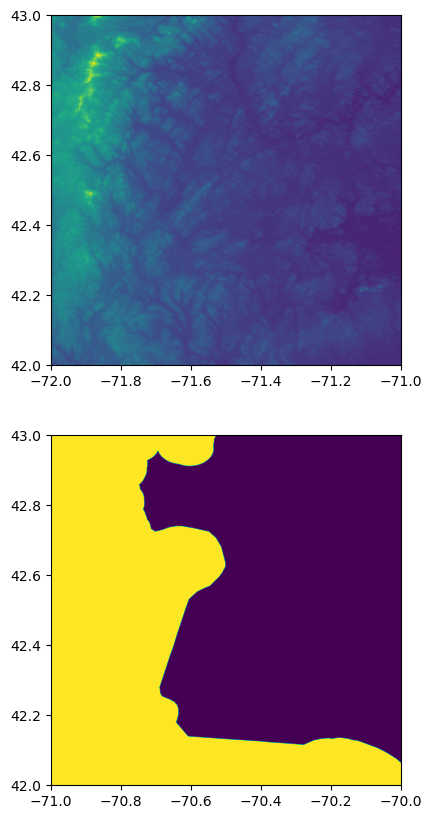

In [6]:
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(2,1,1)
rasterio.plot.show(tile1, ax=ax1, transform=tile1_profile['transform'])
ax2 = fig.add_subplot(2,1,2)
rasterio.plot.show(tile2, ax=ax2, transform=tile2_profile['transform'])


The second part looks weird, right? That's because it contains `nodata` values, which are `-3.4028234663853e+38`. That makes the low end way too low. 

Fortunately, there's a masking function that lest us select all of the non-nodata pixels

In [7]:
with rasterio.open(lowres_tile1_loc) as src:
    tile1_mask = src.read_masks(1)

with rasterio.open(lowres_tile2_loc) as src:
    tile2_mask = src.read_masks(1)


<Axes: >

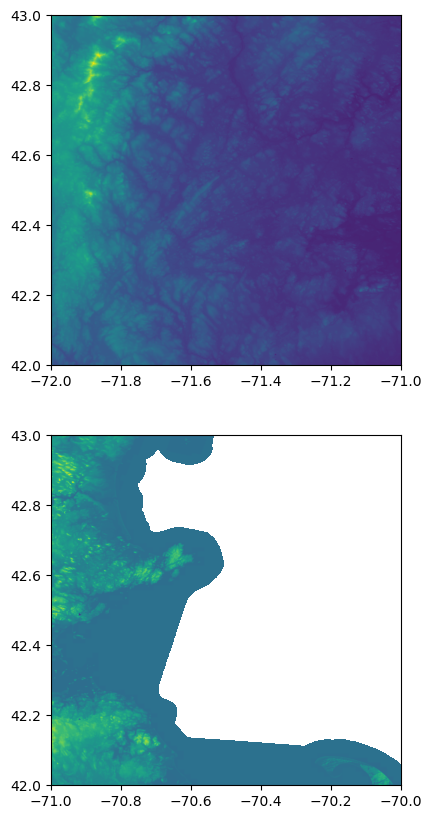

In [8]:
# we use the np.ma.masked_where() function to mask out all the values equal to zero
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(2,1,1)
rasterio.plot.show(np.ma.masked_where(tile1_mask==0, tile1), ax=ax1, transform=tile1_profile['transform'])
ax2 = fig.add_subplot(2,1,2)
rasterio.plot.show(np.ma.masked_where(tile2_mask==0, tile2), ax=ax2, transform=tile2_profile['transform'])

Let's combine the two tiles together into one large mosaic and save it as a geotiff

In [9]:
combined_location = 'combined.tif'

In [10]:
with rasterio.open(lowres_tile1_loc, 'r') as src1:
    with rasterio.open(lowres_tile2_loc, 'r') as src2:
        combined, out_transform = rasterio.merge.merge([src1, src2],
                                                       nodata=src2.profile['nodata'])
        combined_meta = src1.profile.copy()
        combined_meta.update({'driver':'GTiff',
                         'count': combined.shape[0],
                        'height': combined.shape[1],
                        'width': combined.shape[2],
                        'transform': out_transform,
                        'crs': src1.crs})
    with rasterio.open(combined_location, 'w', **combined_meta) as dst:
        dst.write(combined)


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -999999.0, 'width': 5403, 'height': 2703, 'count': 1, 'crs': CRS.from_epsg(4269), 'transform': Affine(0.0003703703707688067, 0.0, -72.00055555609339,
       0.0, -0.0003703703707688067, 43.00055555579519)}


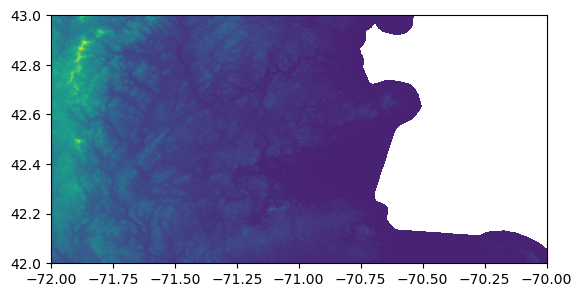

In [11]:
with rasterio.open(combined_location, 'r') as src:
    print(src.meta)
    combined = src.read(1)
    combined_mask = src.read_masks(1)
    combined_transform = src.profile['transform']
    rasterio.plot.show(np.ma.masked_where(combined_mask==0, combined), 
                     transform=combined_transform)

Let's take a look at what cambridge and boston look like on this map

In [17]:
camb_name = "Cambridge, MA, USA"
graph_area_cambridge = ox.geocode_to_gdf(camb_name)
bos_name = "Boston, MA, USA"
graph_area_bos = ox.geocode_to_gdf(bos_name)
local_areas = pd.concat([graph_area_bos, graph_area_cambridge], ignore_index=True)

# Save to local shapefile
# make a directory called local_areas
!mkdir -p local_areas

local_areas.to_crs(epsg=4329).to_file('local_areas/local_areas.shp')

/tmp/ipykernel_1855/1471746731.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  local_areas.to_crs(epsg=4329).to_file('local_areas/local_areas.shp')


In [19]:
local_areas

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-71.19124 42.28294, -71.19123 42.282...",42.396977,42.227911,-70.804488,-71.191244,298419510,relation,2315704,42.355433,-71.060511,"Boston, Suffolk County, Massachusetts, United ...",boundary,administrative,0.920251
1,"POLYGON ((-71.16040 42.38654, -71.15814 42.383...",42.404259,42.352402,-71.063984,-71.160399,298577507,relation,1933745,42.365577,-71.104002,"Cambridge, Middlesex County, Massachusetts, Un...",boundary,administrative,0.824277


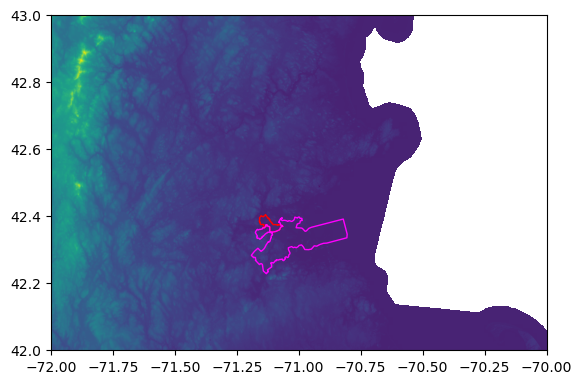

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
p = rasterio.plot.show(np.ma.masked_where(combined_mask==0, combined), 
                       ax=ax, transform=combined_transform)
graph_area_cambridge.to_crs(epsg=4329).plot(ax=ax, facecolor='none', edgecolor='red')
graph_area_bos.to_crs(epsg=4329).plot(ax=ax, facecolor='none', edgecolor='magenta')
plt.show()

We can [crop the raster using these vectors](https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html)

In [21]:
with rasterio.open(combined_location, 'r') as src:
    # mask function crops a raster using a vector data set
    out_image, out_transform = rasterio.mask.mask(src, local_areas['geometry'].values, crop=True)
    out_profile = src.profile
    out_profile.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("masked_elevation_local.tif", "w", **out_profile) as masked_outfile:
    masked_outfile.write(out_image)

In [ ]:
with rasterio.open('masked_elevation_local.tif', 'r') as src:
    print(src.meta)
    local_crop = src.read(1)
    local_crop_mask = src.read_masks(1)
    local_transform = src.profile['transform']
    rasterio.plot.show(np.ma.masked_where(local_crop_mask==0, local_crop), 
                     transform=local_transform)

# GDAL
Another package that's very useful for processing raster is GDAL, which is used behind the scenes for a lot of GIS applications. https://gdal.org/index.html

In this example, we'll be using it to create a hillshade. GDAL is available as a set of command line tools, which are installed in `/opt/conda/bin/`
In particular, we're using `gdaldem` which is the gdal tool for working with digital elevation models. For more info about the capabilities of gdaldem, check the [documentation](https://gdal.org/programs/gdaldem.html#gdaldem)

In [ ]:
#!/opt/conda/bin/gdaldem hillshade combined.tif hs.tif
!gdaldem hillshade combined.tif hs.tif

In [ ]:
with rasterio.open('hs.tif', 'r') as src:
    print(src.meta)
    hillshade = src.read(1)
    hillshade_mask = src.read_masks(1)
    hillshade_transform = src.profile['transform']
    rasterio.plot.show(np.ma.masked_where(hillshade_mask==0, hillshade), 
                     transform=hillshade_transform)

There are also python bindings for the GDAL functions.
- [Example scripts](https://github.com/OSGeo/gdal/tree/master/gdal/swig/python/gdal-utils/osgeo_utils/samples)
- [API reference](https://gdal.org/python/index.html)


Check out the other GDAL command line tools: https://gdal.org/programs/index.html